# Random Forest Model Interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = '/Users/Vishy/Desktop/FastAi-ML/'

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [8]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


## Confidence based on tree variance

In [9]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20609022309103706, 0.24904496283669664, 0.9112333960633063, 0.8892347586099674, 0.8941618594601347]


In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 2.34 s, sys: 114 ms, total: 2.45 s
Wall time: 2.71 s


(9.23144393890744, 0.2636328169981515)

In [12]:
def get_preds(t): 
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 124 ms, sys: 118 ms, total: 241 ms
Wall time: 1.79 s


(9.23144393890744, 0.2636328169981515)

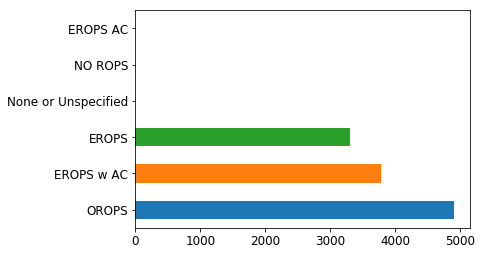

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839204,0.272058
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.571995,0.277218
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683693,0.225138


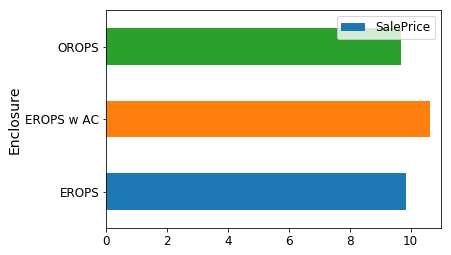

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

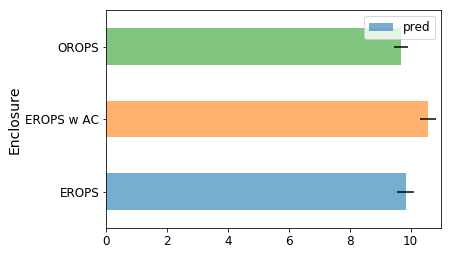

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

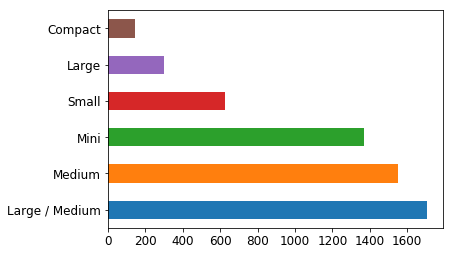

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [18]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.860551,0.344003
Large,10.470589,10.372031,0.381555
Large / Medium,10.691871,10.651208,0.302091
Medium,10.681511,10.605261,0.310724
Mini,9.535147,9.558734,0.244147
Small,10.324448,10.324116,0.308190


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.036787
Compact           0.034887
Small             0.029851
Medium            0.029299
Large / Medium    0.028362
Mini              0.025542
dtype: float64

# Feature importance

In [20]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175161
37,Coupler_System,0.106576
13,ProductSize,0.087887
14,fiProductClassDesc,0.087585
2,ModelID,0.054534
39,Hydraulics_Flow,0.049361
63,saleElapsed,0.049279
10,fiSecondaryDesc,0.044265
38,Grouser_Tracks,0.039092
19,Enclosure,0.036943


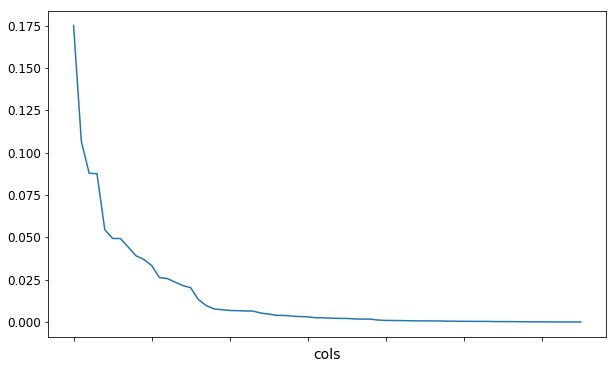

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

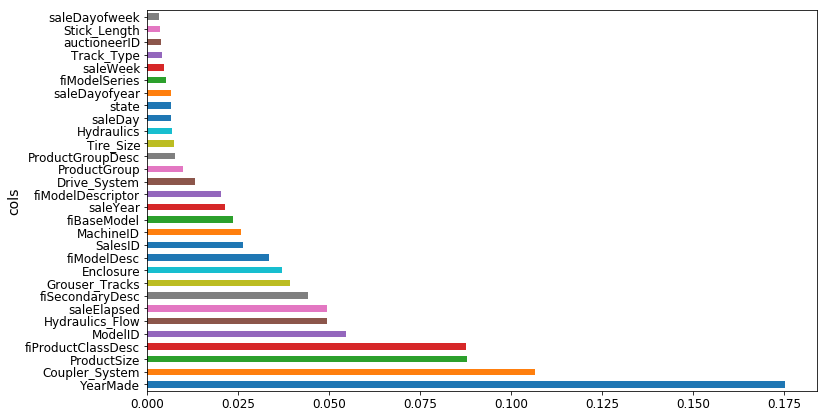

In [23]:
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [25]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20682580620687505, 0.24606448719936913, 0.9105986086299267, 0.8918700871531892, 0.894274455242139]


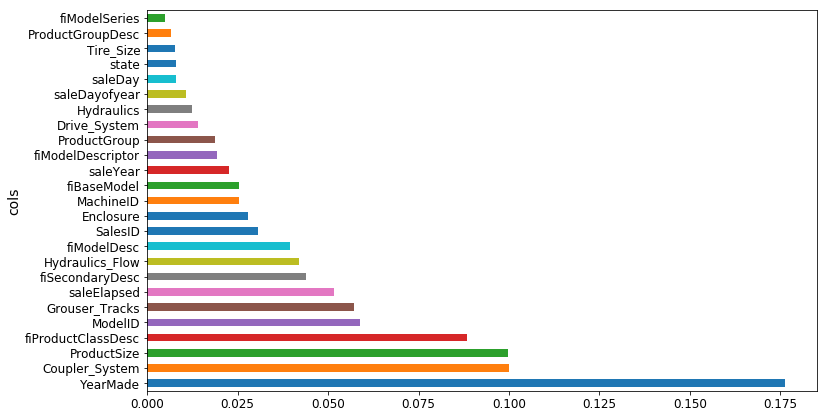

In [27]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# One-hot encoding